## 1. System Initialization

Live feedback system for defect classification with dynamic cluster adaptation

In [6]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report


import skimage.io
from scipy.spatial.distance import cdist

import sys
sys.path.insert(0,'../')
from helper import classification_tools as ct
from helper import visualize as vis

%matplotlib inline

In [7]:
# fc1 features saved from the previous step
fc1_path = Path('..','data','features','VGG16_fc1_features_std.pickle')
assert fc1_path.is_file()

# label encoder model which converts string labels to integers.
le_path = Path('..','models','label_encoder.pickle')
assert le_path.is_file()

# load the data and label encoder into memory
with open(fc1_path, 'rb') as f:
    data = pickle.load(f)

with open(le_path, 'rb') as f:
    le = pickle.load(f)

In [8]:
files = data['filename']  # file paths to each image
fc1 = data['features']  # array containing fc1 features for each file
labels = data['labels']  # string labels for each image
y_gt = le.transform(labels)  # integer labels for each image

## 2. Feedback System Implementation


In [19]:
import pickle
import numpy as np
from pathlib import Path
import tensorflow.keras as keras

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from predictive_model import le # Import label encoder

class FeedbackSystem:
    def __init__(self):
        self.model = None
        self.pca = None
        self.new_data = []
        self.new_labels = []
        self.n_clusters = 7  # Initial cluster count
        self.initial_features = fc1  # From loaded data
        self.load_initial_model()

    def load_initial_model(self):
        """Load pre-trained models with fixed PCA components"""
        self.pca = PCA(n_components=50, whiten=True, svd_solver='full')
        self.pca.fit(fc1)  # Fit on initial dataset
        
        # Initial clustering
        self.model = KMeans(n_clusters=self.n_clusters, init='k-means++', n_init=10)
        self.model.fit(self.pca.transform(fc1))

    def process_feedback(self, features):
        """Process user feedback for a single image"""
        reduced = self.pca.transform([features])
        cluster = self.model.predict(reduced)[0]
        predicted_label = le.inverse_transform([cluster])[0]

        is_correct = input(f"Predicted: {predicted_label}. Correct? (y/n): ").lower() == 'y'
        
        if not is_correct:
            is_new_class = input("New class? (y/n): ").lower() == 'y'
            if is_new_class:
                new_class = input("Class name: ").strip()
                if new_class not in le.classes_:
                    le.classes_ = np.append(le.classes_, new_class)
                    self.n_clusters += 1
                    print(f"Added '{new_class}'. Total clusters: {self.n_clusters}")
                else:
                    print("Class exists. Using existing label.")
            else:
                new_class = input("Correct label: ").strip()
                if new_class not in le.classes_:
                    print("Error: Invalid label")
                    return

            self.new_data.append(features)
            self.new_labels.append(new_class)
            print("Feedback stored. Retrain when ready.")
        else:
            print("Correct prediction recorded.")

    def retrain_model(self):
        """Quick retrain using only new feedback data"""
        if not self.new_data:
            print("No new data to retrain")
            return
        combined_data = np.vstack([self.initial_features, self.new_data])
        # Retrain PCA on combined data (optional but recommended)
        self.pca = PCA(n_components=50, whiten=True, svd_solver='full')
        self.pca.fit(combined_data)
        # Convert labels to integers
        encoded_labels = le.transform(self.new_labels)
        
        # Apply PCA transform
        transformed = self.pca.transform(combined_data)    

        # Retrain with updated cluster count
        self.model = KMeans(
            n_clusters=self.n_clusters,
            init='k-means++',
            n_init=10  # Reduced for faster training
        )
        self.model.fit(transformed)
        
        print(f"Model retrained with {self.n_clusters} clusters")

## 3. Feature Extraction Functions

In [20]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image


# Initialize VGG16 feature extractor (add to FeedbackSystem __init__ or global scope)
def create_feature_extractor():
    base_model = VGG16(weights='imagenet', include_top=True)
    return Model(inputs=base_model.input, 
                 outputs=base_model.get_layer('fc1').output)

fc1_extractor = create_feature_extractor()

# Revised feature extraction function
def extract_features(img_path):
    """Proper fc1 feature extraction"""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    features = fc1_extractor.predict(np.expand_dims(img_array, axis=0))
    return features.flatten()  # Now returns 4096-dim vector

## 4. Demonstration Workflow

In [21]:
# Initialize feedback system
fb_system = FeedbackSystem()

In [22]:
# Demo sequence
demo_images = [
    ("dataset_demo_processed/Kt_1.bmp", True),
    ("dataset_demo_processed/Kt_2.bmp", True),
    ("data/images_preprocessed/images_histeq_resize/Cr_1.bmp", False)
]

for img_path, is_new in demo_images:
    features = extract_features(img_path)
    fb_system.process_feedback(features)
    
    if is_new:
        fb_system.retrain_model()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


ValueError: Buffer dtype mismatch, expected 'const double' but got 'float'

## 5. Visualization (Optional)

Optional: Add visualization code from 03_standard.ipynb here

Include t-SNE plots or confusion matrices if time permits

## 6. Image Processing (run single time)

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import os
from pathlib import Path
import skimage.exposure
import skimage.io
import skimage.transform

%matplotlib inline

In [2]:
root = Path('dataset_demo') # directory where demo images are stored
assert root.is_dir() # make sure this directory is found
output_root = Path('dataset_demo_processed')  # Output directory
os.makedirs(output_root, exist_ok=True)  # Create output directory
files = sorted(root.glob('*.bmp'), key=lambda file : file.name) # read files and sort by name so order is consistent
assert len(files) == 10 # make sure all images are found currently 10

In [3]:
def pre_process_pipeline(input_path, output_dir):
    """Process images identically to 01_preprocess.ipynb"""
    # Load image as grayscale
    im = skimage.io.imread(input_path, as_gray=True)
    
    # Convert to float32 for histogram equalization
    im = skimage.img_as_float32(im)
    
    # Apply adaptive histogram equalization
    im_eq = skimage.exposure.equalize_adapthist(im)
    
    # Resize to 224x224 for VGG16 compatibility
    im_resized = skimage.transform.resize(im_eq, (224, 224))
    
    # Convert back to 8-bit unsigned integer format
    im_processed = skimage.img_as_ubyte(im_resized)
    
    # Save processed image
    output_path = output_dir / input_path.name
    skimage.io.imsave(output_path, im_processed)
    
    return im_processed

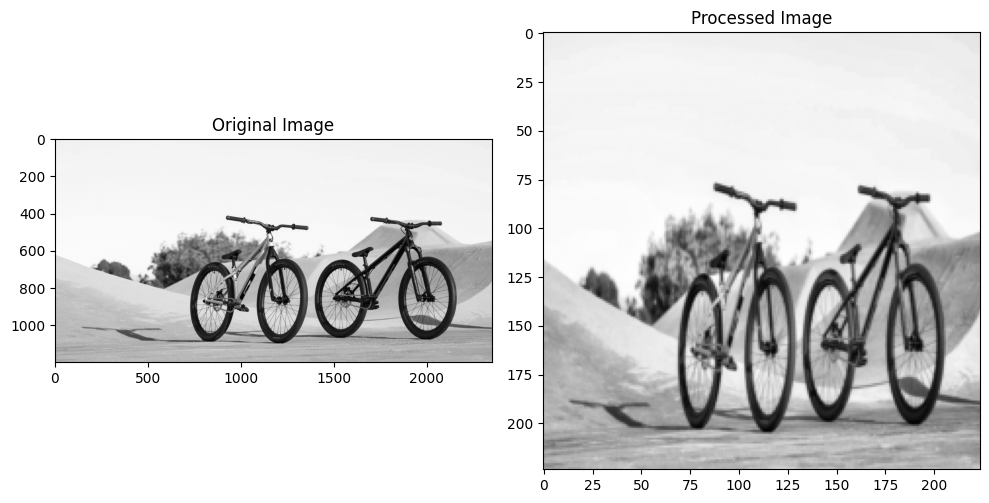

All images processed successfully!


In [4]:
# Process all images
processed_images = []
for file in files:
    processed_img = pre_process_pipeline(file, output_root)
    processed_images.append(processed_img)

# Verify processing with a sample image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Original image
im_original = skimage.io.imread(files[0], as_gray=True)
ax[0].imshow(im_original, cmap='gray')
ax[0].set_title('Original Image')

# Processed image
ax[1].imshow(processed_images[0], cmap='gray')
ax[1].set_title('Processed Image')

plt.tight_layout()
plt.show()

# Final verification
assert len(list(output_root.glob("*.bmp"))) == 10, "Processing failed for some images"
print("All images processed successfully!")

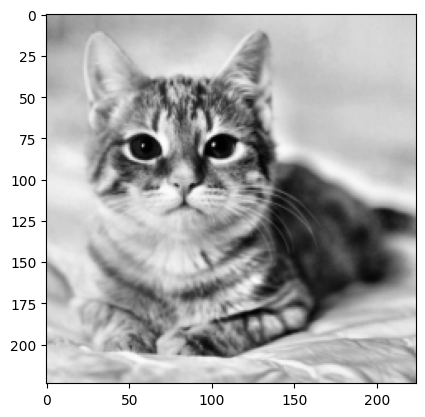

In [5]:
im_path = Path('dataset_demo_processed','Kt_3.bmp') # path to image
assert im_path.exists()

im = skimage.io.imread(im_path, as_gray=True) # load image

# display the image to verify it loads as expected
fig, ax = plt.subplots()
ax.imshow(im, cmap='gray')